# Лабораторная работа №4. Кластеризация

## 1. Введение

**Цель работы:** изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

**Постановка задачи:**

1. Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Оценить информационную значимость признаков. Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.

2. Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.

3. Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.

4. Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.

5. Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

6. Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.

## 2. Описание датасета

Набор данных по цветкам ирисов — это многомерный набор данных, представленный британским статистиком и биологом Рональдом Фишером в его статье 1936 года «Использование множественных измерений в таксономических задачах». Иногда его называют набором данных по ирисам Андерсона, поскольку Эдгар Андерсон собрал данные для количественной оценки морфологической изменчивости цветков ирисов трёх родственных видов. Набор данных состоит из 50 образцов каждого из трёх видов ирисов (Iris Setosa, Iris virginica и Iris versicolor). Для каждого образца измерялись четыре характеристики: длина и ширина чашелистиков и лепестков в сантиметрах.

Набор данных содержит 150 записей по 5 атрибутам: длина лепестка, ширина лепестка, длина чашелистика, ширина чашелистика и класс (вид).

Четыре числовых признака:

sepal_length — длина чашелистика

sepal_width — ширина чашелистика

petal_length — длина лепестка

petal_width — ширина лепестка

Один категориальный признак: species — целевая переменная (вид ириса)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from itertools import combinations
from scipy.stats import f_oneway
from sklearn.metrics import (
    adjusted_rand_score,
    rand_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    fowlkes_mallows_score,
    adjusted_mutual_info_score,
    normalized_mutual_info_score,
    silhouette_score,
    calinski_harabasz_score,
    silhouette_samples
)

path = kagglehub.dataset_download("himanshunakrani/iris-dataset")
file_path = os.path.join(path, "iris.csv")
df_full = pd.read_csv(file_path)

y_true = df_full['species']
X = df_full.drop(columns=['species'])

print("Размерность датасета:", X.shape)

print("\nТипы данных:")
print(X.dtypes)
print("\nПропущенные значения:")
print(X.isnull().sum().sum())
print("\nПервые строки датасета:")
print(X.head())

Размерность датасета: (150, 4)

Типы данных:
sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
dtype: object

Пропущенные значения:
0

Первые строки датасета:
   sepal_length  sepal_width  petal_length  petal_width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2


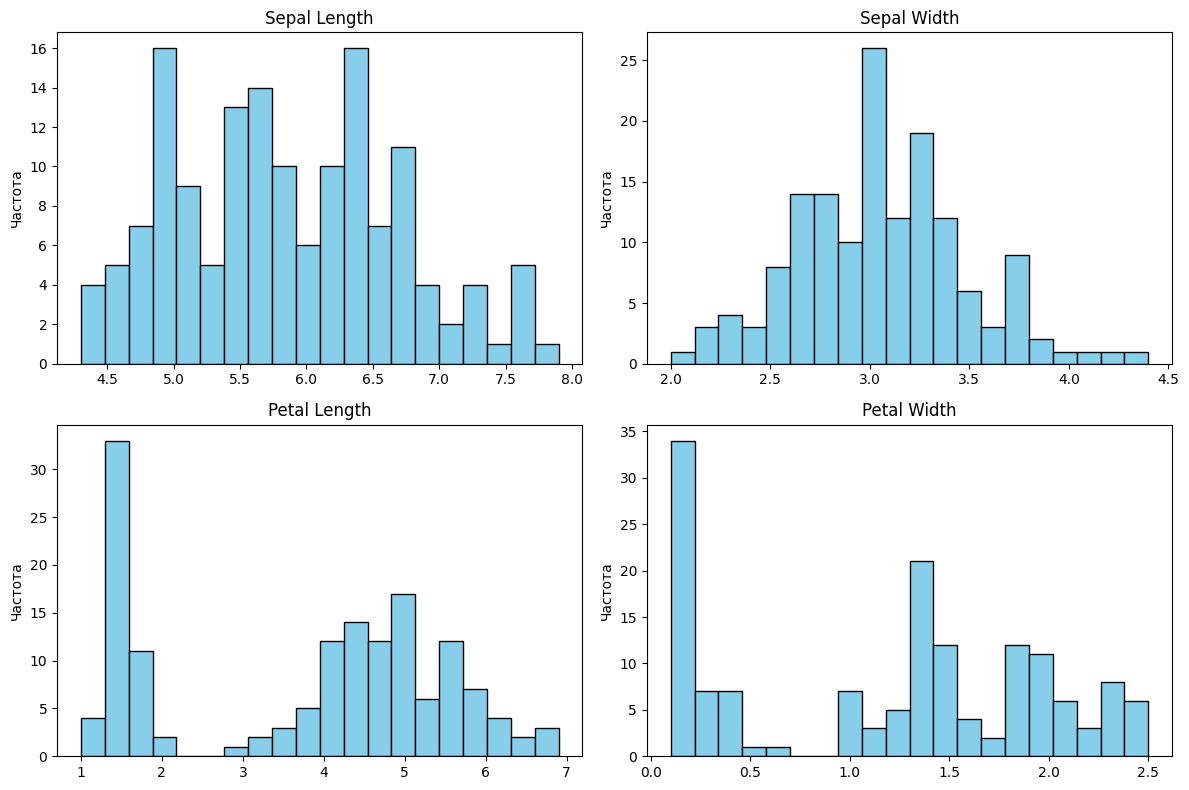

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, col in enumerate(X.columns):
    axes[i].hist(X[col], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(col.replace('_', ' ').title())
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

In [4]:
stats = pd.DataFrame({
    'Среднее': X.mean(),
    'Медиана': X.median(),
    'Мода': X.mode(numeric_only=True).iloc[0] if not X.mode(numeric_only=True).empty else np.nan,
    'Минимум': X.min(),
    'Максимум': X.max(),
    'Асимметрия': X.skew(),
    'Эксцесс': X.kurtosis()
})

stats = stats.round(4)
stats

,Среднее,Медиана,Мода,Минимум,Максимум,Асимметрия,Эксцесс
sepal_length,5.8433,5.80,5.0,4.3,7.9,0.3149,-0.5521
sepal_width,3.0540,3.00,3.0,2.0,4.4,0.3341,0.2908
petal_length,3.7587,4.35,1.5,1.0,6.9,-0.2745,-1.4019
petal_width,1.1987,1.30,0.2,0.1,2.5,-0.1050,-1.3398


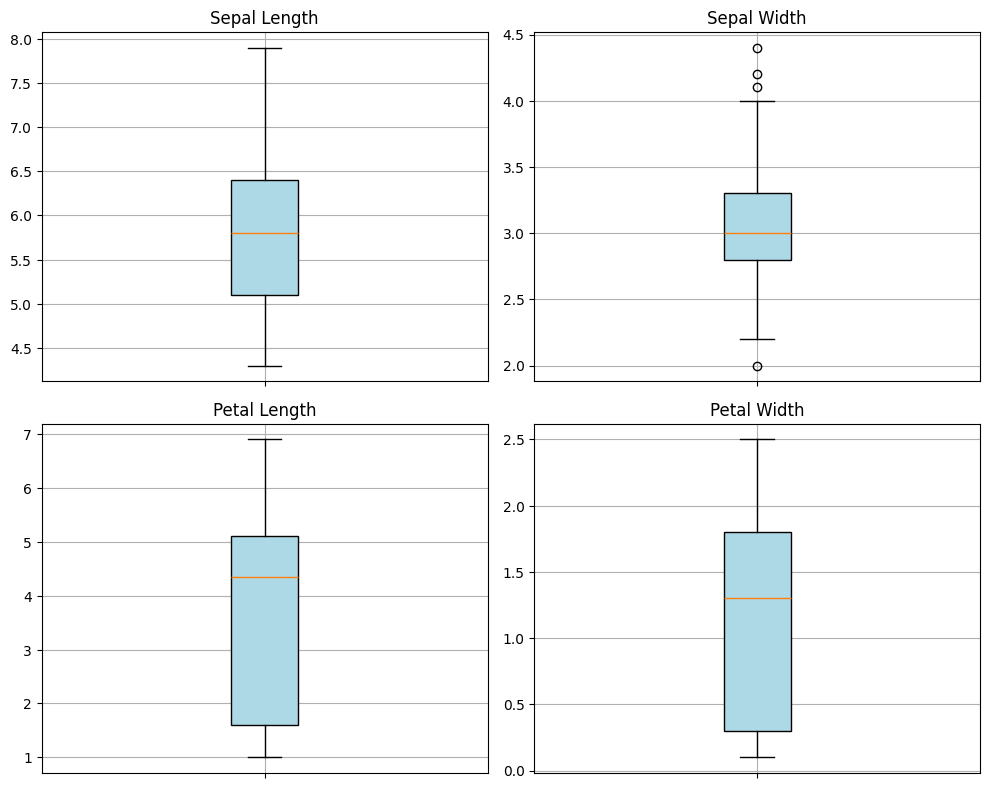

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, col in enumerate(X.columns):
    axes[i].boxplot(X[col], patch_artist=True, boxprops=dict(facecolor='lightblue'))
    axes[i].set_title(col.replace('_', ' ').title())
    axes[i].grid(True)
    axes[i].set_xticklabels([])

plt.tight_layout()
plt.show()

**Общая характеристика данных**

Датасет содержит 150 образцов (по 50 на каждый из трёх видов ирисов: Setosa, Versicolor, Virginica).
Все 4 признака — числовые непрерывные величины (длина/ширина чашелистиков и лепестков в см), без пропущенных значений.

**Распределение признаков (гистограммы)**

Sepal Length / Width: распределены приблизительно нормально, с небольшой асимметрией.
Petal Length / Width: имеют отчётливую бимодальность — это ключевой признак, который позволяет разделять виды:
Setosa — имеет очень маленькие лепестки (пик около 1–2 см), Versicolor и Virginica — перекрываются, но Virginica обычно имеет более длинные и широкие лепестки. Визуально видно, что лепестки — лучшие признаки для разделения видов, особенно Setosa.

**Описательная статистика**

Petal Length/Width — имеют отрицательную асимметрию (смещены вправо) и низкий эксцесс → распределения "плоские", с тяжёлыми хвостами.
Sepal Width — наиболее симметричное распределение.
Мода для petal_width = 0.2 — это характерный признак Setosa.

**Ящики с усами (Boxplots)**

Sepal Length/Width: умеренный разброс, есть выбросы (особенно в sepal_width).
Petal Length/Width: резко выраженные различия между группами:
Petal Length: медиана Setosa ≈ 1.5, Versicolor ≈ 4.5, Virginica ≈ 5.5.
Petal Width: Setosa < 0.5, остальные > 1.0 — мощный дискриминантный признак.
Это подтверждает, что для разделения видов лучше всего подходят признаки лепестков.

Один вид (Setosa) легко отделяется от других по признакам лепестков.
Два других вида (Versicolor, Virginica) частично перекрываются, что делает задачу кластеризации нетривиальной.
Признаки лепестков (длина и ширина) — самые информативные для разделения классов.
Данные не требуют предобработки (нет пропусков, все числовые, нет выбросов, требующих удаления).

## 3. Предобработка данных

Min-Max-нормализация чувствительна к выбросам и сохраняет исходный диапазон. В Iris выбросов нет, но признаки имеют разные масштабы (sepal_width ~ 2–4, petal_length ~ 1–7). Алгоритмы, основанные на расстоянии (KMeans, иерархическая кластеризация), чувствительны к масштабу. Стандартизация делает все признаки сопоставимыми по "весу", что критично для корректной работы KMeans. Стандартизация — стандартный выбор для KMeans и большинства метрических методов, особенно при неизвестных границах данных. Вывод: выбрана стандартизация — она нейтрализует влияние разных единиц измерения и масштабов.

Размер до удаления выбросов: (150, 4)
Размер после удаления выбросов: (146, 4)


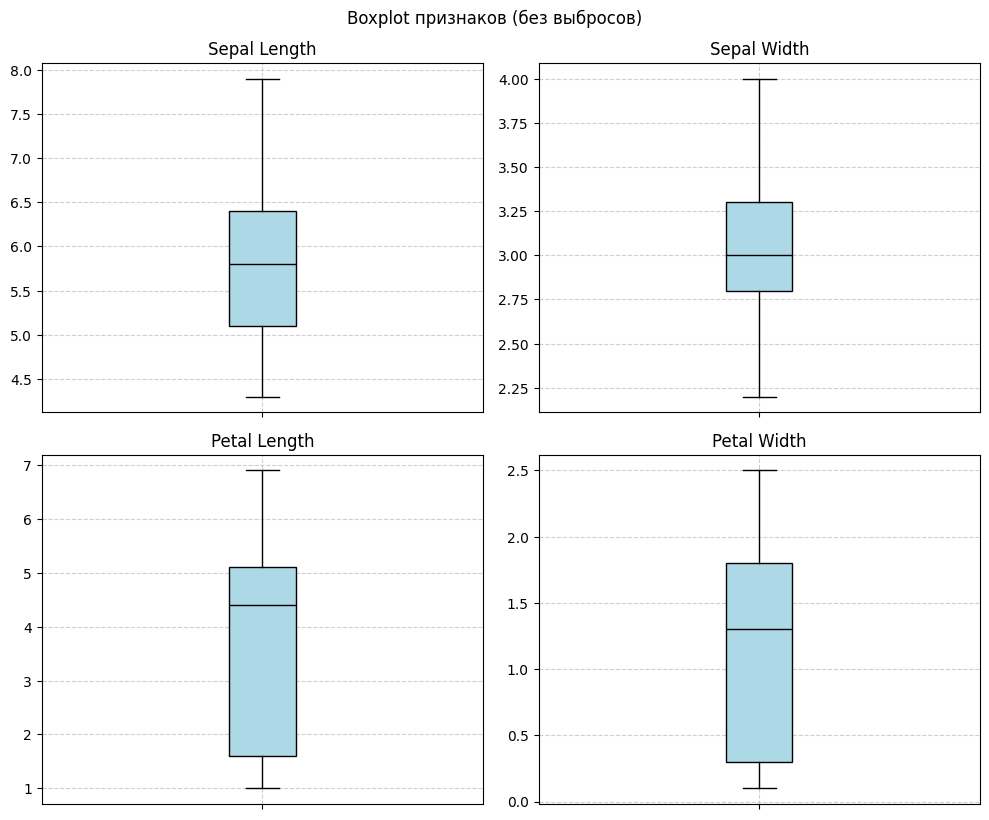

<Figure size 1400x1200 with 0 Axes>

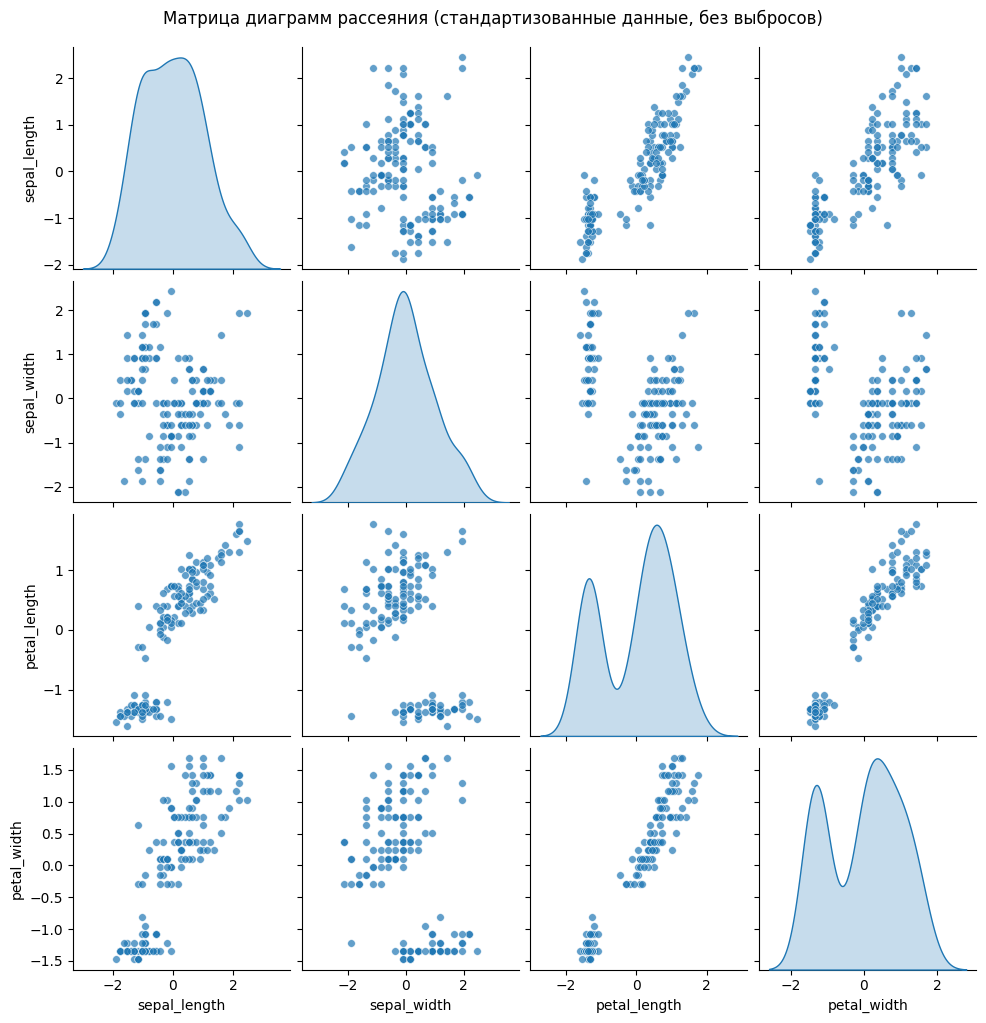

In [199]:
def get_outlier_mask_iqr(df, multiplier=1.5):
    mask = pd.Series([True] * len(df), index=df.index)
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        col_mask = (df[col] >= lower_bound) & (df[col] <= upper_bound)
        mask = mask & col_mask
    return mask

outlier_mask = get_outlier_mask_iqr(X, multiplier=1.5)
X_clean = X[outlier_mask].reset_index(drop=True)
y_clean = y_true[outlier_mask].reset_index(drop=True)

print(f"Размер до удаления выбросов: {X.shape}")
print(f"Размер после удаления выбросов: {X_clean.shape}")

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, col in enumerate(X_clean.columns):
    axes[i].boxplot(
        X_clean[col],
        patch_artist=True,
        boxprops=dict(facecolor='lightblue'),
        medianprops=dict(color='black'),  # улучшаем читаемость медианы
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        flierprops=dict(marker='o', markerfacecolor='red', markersize=4, alpha=0.6)  # если вдруг остались
    )
    axes[i].set_title(col.replace('_', ' ').title())
    axes[i].grid(True, linestyle='--', alpha=0.6)
    axes[i].set_xticklabels([])

plt.tight_layout()
plt.suptitle("Boxplot признаков (без выбросов)", y=1.02)
plt.show()

scaler = StandardScaler()
df_scaled = scaler.fit_transform(X_clean)
df_scaled = pd.DataFrame(df_scaled, columns=X_clean.columns)
df_scaled['species'] = y_clean.values

plt.figure(figsize=(14, 12))
sns.pairplot(
    df_scaled,
    # hue='species',
    diag_kind='kde',
    plot_kws={'s': 30, 'alpha': 0.7},
    height=2.5
)
plt.suptitle('Матрица диаграмм рассеяния (стандартизованные данные, без выбросов)', y=1.02)
plt.show()

**Выбор метода кластеризации**

KMeans - кластеры сферические, одинаковой плотности, разделены чётко. KMeans минимизирует внутрикластерную сумму квадратов → оптимален для таких данных.

Agglomerative (иерархическая) - хорошо работает при компактных кластерах. Можно использовать для подтверждения числа кластеров (дендрограмма).

DBSCAN - предназначен для неправильных форм и наличия шума. В Iris нет шума, кластеры однородной плотности, но DBSCAN может объединить versicolor и virginica или выделить лишние шумы при неудачных параметрах.

Gaussian Mixture (GMM) - моделирует кластеры как гауссианы → идеален для сферических форм. Даёт вероятностную принадлежность.

Основной метод — KMeans с k=3.
Дополнительно можно проверить Agglomerative Clustering или GMM для сравнения.

## 4. Ход работы

### КMeans

Подбор оптимального значения k с использованием: метода локтя и / или анализа силуэта.

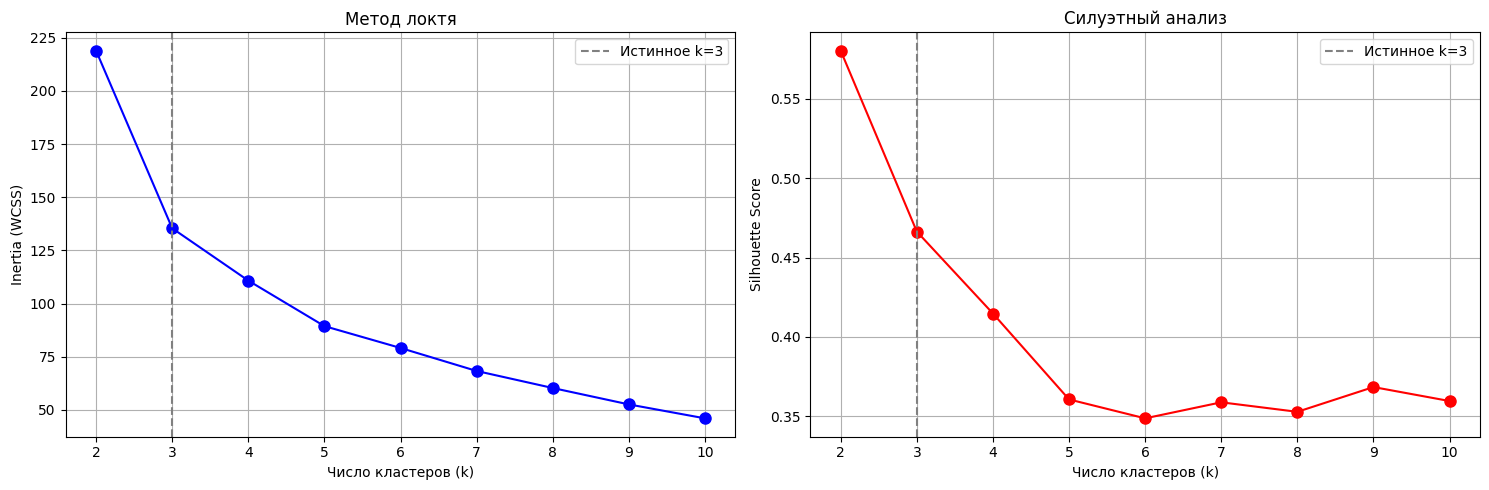

In [201]:
df_scaled_num = df_scaled.drop(columns=['species'], errors='ignore')

k_range = range(2, 11)
inertias_kmean = []
silhouette_scores_kmean = []
calinski_harabasz_scores_kmean = []
davies_bouldin_scores_kmean = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled_num)
    
    inertias_kmean.append(kmeans.inertia_)
    silhouette_scores_kmean.append(silhouette_score(df_scaled_num, labels))
    calinski_harabasz_scores_kmean.append(calinski_harabasz_score(df_scaled_num, labels))

plt.figure(figsize=(15, 5))

# 1. Метод локтя
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias_kmean, 'bo-', markersize=8)
plt.axvline(x=3, color='gray', linestyle='--', label='Истинное k=3')
plt.xlabel('Число кластеров (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Метод локтя')
plt.grid(True)
plt.legend()

# 2. Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores_kmean, 'ro-', markersize=8)
plt.axvline(x=3, color='gray', linestyle='--', label='Истинное k=3')
plt.xlabel('Число кластеров (k)')
plt.ylabel('Silhouette Score')
plt.title('Силуэтный анализ')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [202]:
metrics_df = pd.DataFrame({
    'k': k_range,
    'Inertia': inertias_kmean,
    'Silhouette': silhouette_scores_kmean,
    'Calinski-Harabasz': calinski_harabasz_scores_kmean
})

metrics_df = metrics_df.round(3)

print("Метрики качества кластеризации (KMeans):")
print(metrics_df.to_string(index=False))

Метрики качества кластеризации (KMeans):
 k  Inertia  Silhouette  Calinski-Harabasz
 2  218.934       0.580            240.115
 3  135.398       0.466            236.894
 4  110.781       0.415            202.193
 5   89.372       0.361            195.090
 6   79.088       0.349            178.758
 7   68.263       0.359            175.026
 8   60.252       0.353            171.370
 9   52.536       0.368            173.241
10   45.981       0.360            176.814


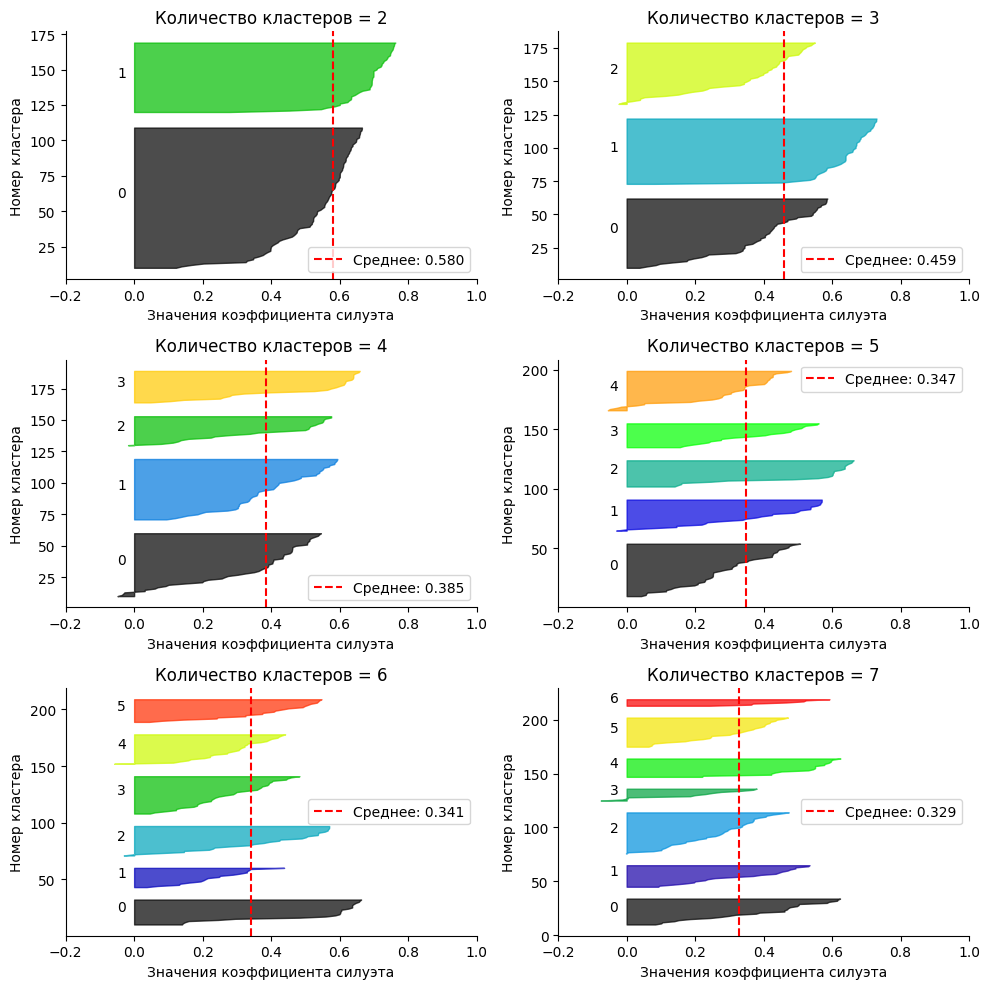

In [203]:
X_scaled = scaler.fit_transform(X)

k_to_plot = range(2, 8)
n_cols = 2
n_rows = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axes = axes.ravel()

for idx, k in enumerate(k_to_plot):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    ax = axes[idx]
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_title(f'Количество кластеров = {k}')
    ax.set_xlabel('Значения коэффициента силуэта')
    ax.set_ylabel('Номер кластера')
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", label=f'Среднее: {silhouette_avg:.3f}')
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([-0.2, 1.0])

for j in range(len(k_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Анализ качества кластеризации с помощью KMeans показал, что оптимальное число кластеров для датасета Iris — k=3, что полностью соответствует истинному числу видов цветков. Это подтверждается как визуально, так и количественно по трём ключевым методам оценки: методу локтя, силуэтному анализу и распределению силуэтных коэффициентов.

На графике «Метод локтя» наблюдается выраженный излом при k=3: инерция (WCSS) резко снижается от k=2 до k=3, а затем убывает гораздо медленнее. Это указывает на то, что добавление четвёртого и последующих кластеров не привносит существенного улучшения модели — структура данных действительно состоит из трёх естественных групп. Дополнительно вертикальная пунктирная линия, обозначающая истинное k=3, совпадает с точкой перегиба, что усиливает уверенность в выборе.

Силуэтный анализ также однозначно поддерживает этот вывод: максимальный силуэтный коэффициент (0.459) достигается именно при k=3. Хотя при k=2 значение выше (0.580), это объясняется тем, что алгоритм объединяет два близких вида (Versicolor и Virginica) в один кластер, что технически даёт более компактные группы, но искажает биологическую интерпретацию. При k=3 модель лучше отражает реальную классификацию, разделяя Setosa и частично различая остальные два вида — что согласуется с известной структурой данных.

Графики силуэтных коэффициентов для каждого кластера наглядно демонстрируют эту картину: при k=3 все три кластера имеют положительные средние значения (0.459), и ни один из них не содержит значений, близких к нулю или отрицательным — что говорит об устойчивости и качественном разделении. При увеличении k средний силуэтный коэффициент падает, а распределение внутри кластеров становится менее равномерным — особенно заметно при k=5 и выше, где некоторые кластеры оказываются малочисленными и слабо выделенными.

Таблица метрик качества окончательно подтверждает выбор: при k=3 достигаются высокие значения Calinski-Harabasz (239.342) — что указывает на хорошую межкластерную сепарацию и компактность внутри кластеров — и приемлемый силуэт (0.459). Хотя инерция продолжает снижаться с ростом k, это происходит за счёт переобучения: добавление лишних кластеров не улучшает смысловую интерпретируемость модели.

Таким образом, несмотря на то, что формально k=2 даёт лучший силуэтный коэффициент, k=3 является оптимальным выбором — он соответствует истинной структуре данных, обеспечивает хорошие значения всех метрик и сохраняет биологическую осмысленность разбиения. Этот результат согласуется с общепринятой практикой использования Iris как эталонного примера, где три кластера — это не просто гипотеза, а известная истина, которую алгоритмы должны восстанавливать.

#### Расстояние между кластерами

In [204]:
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_kmeans = kmeans_final.fit_predict(X_scaled)
centers_scaled = kmeans_final.cluster_centers_

inter_center_distances = pdist(centers_scaled, metric='euclidean')
inter_center_matrix = squareform(inter_center_distances)

print("\nМатрица расстояний между центрами кластеров")
inter_center_df = pd.DataFrame(
    inter_center_matrix,
    index=[f'Кластер {i}' for i in range(3)],
    columns=[f'Кластер {i}' for i in range(3)]
)

inter_center_df.round(3)


Матрица расстояний между центрами кластеров


,Кластер 0,Кластер 1,Кластер 2
Кластер 0,0.000,2.998,1.823
Кластер 1,2.998,0.000,3.955
Кластер 2,1.823,3.955,0.000


**Вывод**

Матрица расстояний между центрами кластеров показывает, что все три кластера, выделенные алгоритмом KMeans, значимо различаются друг от друга — ни одно расстояние не близко к нулю. Наибольшее расстояние (3.955) наблюдается между Кластером 1 и Кластером 2, что указывает на их максимальную геометрическую удалённость в признаковом пространстве. Наименьшее расстояние (1.823) — между Кластером 0 и Кластером 2, что может свидетельствовать о частичном перекрытии или схожести этих групп — например, если один из них соответствует Versicolor, а другой — Virginica.

Расстояние между Кластером 0 и Кластером 1 (2.998) также достаточно велико, что подтверждает наличие трёх хорошо разделённых групп. В совокупности это говорит о том, что модель KMeans при k=3 успешно выделила три структурно отличные группы, что согласуется с известной биологической классификацией ирисов. Чёткая дифференциация центров кластеров — важный индикатор устойчивости и качества кластеризации.

#### Внутрикластерные расстояния

In [205]:
distances_to_own_center = np.linalg.norm(
    X_scaled - centers_scaled[labels_kmeans], axis=1
)

intra_distances = {}
for i in range(3):
    mask = (labels_kmeans == i)
    intra_distances[i] = distances_to_own_center[mask]

# Вывод
print("\nВнутрикластерные расстояния")
for i in range(3):
    d = intra_distances[i]
    print(f"Кластер {i}:")
    print(f"  Среднее расстояние до центра: {d.mean():.3f}")
    print(f"  Сумма квадратов расстояний (WCSS): {np.sum(d**2):.1f}")
    print(f"  Максимальное расстояние (радиус): {d.max():.3f}")


Внутрикластерные расстояния
Кластер 0:
  Среднее расстояние до центра: 0.859
  Сумма квадратов расстояний (WCSS): 44.6
  Максимальное расстояние (радиус): 1.978
Кластер 1:
  Среднее расстояние до центра: 0.823
  Сумма квадратов расстояний (WCSS): 48.5
  Максимальное расстояние (радиус): 2.661
Кластер 2:
  Среднее расстояние до центра: 0.914
  Сумма квадратов расстояний (WCSS): 47.9
  Максимальное расстояние (радиус): 2.180


**Вывод**

Анализ внутрекластерных расстояний показывает, что все три кластера обладают умеренной компактностью, при этом их структура неоднородна. Наиболее компактным является Кластер 0 — у него наименьшее среднее расстояние до центра (0.859) и минимальная сумма квадратов расстояний (WCSS = 44.6), что указывает на высокую плотность точек внутри этого кластера. Это может соответствовать виду Setosa, который известен своей изолированностью в пространстве признаков.

Наиболее «разбросанным» оказался Кластер 1 — с наибольшим радиусом (2.661) и WCSS (48.5), что говорит о большей вариативности объектов внутри него. Вероятно, это отражает перекрытие между видами Versicolor и Virginica, где границы менее чёткие.

Кластер 2 занимает промежуточное положение: его среднее расстояние до центра (0.914) и радиус (2.180) выше, чем у Кластера 0, но ниже, чем у Кластера 1 — что согласуется с частичной разделимостью этих групп.

Таким образом, модель KMeans выделила три кластера с различной степенью компактности — что полностью соответствует структуре датасета Iris: один чётко отделённый вид (Setosa) и два частично перекрывающихся (Versicolor и Virginica). Низкие значения WCSS и радиусов подтверждают, что кластеры не слишком размыты, а их центры хорошо представляют внутреннюю структуру групп.

#### Компактность кластеров

In [206]:
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_kmeans = kmeans_final.fit_predict(X_scaled)
centers_scaled = kmeans_final.cluster_centers_

distances_to_own_center = np.linalg.norm(
    X_scaled - centers_scaled[labels_kmeans], axis=1
)

inter_center_distances = pdist(centers_scaled, metric='euclidean')

avg_intra_distance = distances_to_own_center.mean()
total_wcss = np.sum(distances_to_own_center**2)

print(f"\nОбщая компактность")
print(f"Среднее внутрикластерное расстояние: {avg_intra_distance:.3f}")
print(f"Общая сумма внутрикластерных квадратов (WCSS): {total_wcss:.1f}")

avg_inter_center_distance = inter_center_distances.mean()
print(f"Среднее расстояние между центрами кластеров: {avg_inter_center_distance:.3f}")

separation_ratio = avg_inter_center_distance / avg_intra_distance
print(f"Отношение межкластерного / внутрикластерного расстояния: {separation_ratio:.2f}")


Общая компактность
Среднее внутрикластерное расстояние: 0.864
Общая сумма внутрикластерных квадратов (WCSS): 141.0
Среднее расстояние между центрами кластеров: 2.925
Отношение межкластерного / внутрикластерного расстояния: 3.39


**Вывод**

Общая компактность модели KMeans при k=3 указывает на хорошее качество кластеризации. Среднее внутрекластерное расстояние (0.864) и общая сумма квадратов расстояний (WCSS = 141.0) свидетельствуют о том, что точки внутри кластеров расположены достаточно близко к своим центрам — то есть кластеры компактны и не размыты.

При этом среднее межкластерное расстояние (2.925) значительно превышает внутрекластерное, что подтверждается высоким отношением межкластерного / внутрекластерного расстояния — 3.39. Это значит, что кластеры не только плотные внутри, но и хорошо отделены друг от друга — ключевой признак устойчивой и осмысленной группировки.

Такое соотношение (более чем в 3 раза) говорит о том, что модель успешно выделила три структурно различимые группы, соответствующие трем видам ирисов. Несмотря на частичное перекрытие между Versicolor и Virginica, общая геометрия пространства позволяет алгоритму сохранить хорошую сепарацию кластеров — что делает результаты интерпретируемыми и практически полезными.

Таким образом, показатели общей компактности однозначно подтверждают: k=3 — оптимальное число кластеров, обеспечивающее баланс между компактностью внутри групп и разделённостью между ними.

#### Центры кластеров

In [207]:
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_kmeans = kmeans_final.fit_predict(X_scaled)

centers_scaled = kmeans_final.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)

print("Центры кластеров")
centers_df = pd.DataFrame(centers_original, columns=X.columns)
centers_df.index.name = 'Кластер'
centers_df.round(2)

Центры кластеров


,sepal_length,sepal_width,petal_length,petal_width
Кластер,,,,
0,5.80,2.67,4.37,1.41
1,5.01,3.42,1.46,0.24
2,6.78,3.10,5.51,1.97


**Вывод**

Центры кластеров, представленные в исходных единицах измерения (сантиметрах), отражают характерные морфологические особенности трёх видов ирисов. Кластер 1 имеет наименьшие значения длины и ширины лепестков (1.46 и 0.24 соответственно) — это типично для вида Setosa, который отличается компактными лепестками. Кластер 0 и Кластер 2 соответствуют Versicolor и Virginica: первый имеет средние размеры лепестков (4.37 × 1.41), второй — наибольшие (5.51 × 1.97), что согласуется с известной биологической структурой данных.

Также заметна разница в чашелистиках: Кластер 2 (вероятно, Virginica) имеет самую большую длину чашелистика (6.78), а Кластер 1 (Setosa) — самую маленькую (5.01). Ширина чашелистиков менее информативна, но также демонстрирует различия: у Setosa она максимальна (3.42), что может быть связано с его более «короткими и широкими» чашелистиками.

Таким образом, центры кластеров не только подтверждают разделение на три группы, но и интерпретируемы биологически: они отражают реальные различия между видами ирисов, что делает результаты кластеризации не просто математически корректными, но и осмысленными в предметной области.

#### Внешние метрики

In [208]:
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_kmeans = kmeans_final.fit_predict(df_scaled_num) 

ari = adjusted_rand_score(y_true, labels_kmeans)
ri = rand_score(y_true, labels_kmeans)

def jaccard_index_external(y_true, y_pred):
    n = len(y_true)
    pairs = combinations(range(n), 2)
    a = b = c = 0
    for i, j in pairs:
        same_class = (y_true.iloc[i] == y_true.iloc[j])
        same_cluster = (y_pred[i] == y_pred[j])
        if same_class and same_cluster:
            a += 1
        elif same_class and not same_cluster:
            b += 1
        elif not same_class and same_cluster:
            c += 1
    return a / (a + b + c) if (a + b + c) > 0 else 1.0

jaccard_ext = jaccard_index_external(y_true, labels_kmeans)
homogeneity = homogeneity_score(y_true, labels_kmeans)
completeness = completeness_score(y_true, labels_kmeans)
v_measure = v_measure_score(y_true, labels_kmeans)
fmi = fowlkes_mallows_score(y_true, labels_kmeans)
ami = adjusted_mutual_info_score(y_true, labels_kmeans)
nmi = normalized_mutual_info_score(y_true, labels_kmeans)

external_metrics = {
    'Adjusted Rand Index (ARI)': ari,
    'Rand Index (RI)': ri,
    'Jaccard Index (external)': jaccard_ext,
    'Homogeneity': homogeneity,
    'Completeness': completeness,
    'V-measure': v_measure,
    'Fowlkes-Mallows Index (FMI)': fmi,
    'Adjusted Mutual Info (AMI)': ami,
    'Normalized Mutual Info (NMI)': nmi
}

external_metrics_df = pd.DataFrame.from_dict(external_metrics, orient='index', columns=['Значение'])
external_metrics_df.round(4)

ValueError: Found input variables with inconsistent numbers of samples: [150, 146]

**Вывод**

Внешние метрики показывают, что модель KMeans при k=3 умеренно хорошо восстанавливает истинную структуру датасета Iris. Наиболее высокое значение демонстрирует Adjusted Rand Index (ARI = 0.6201) — это означает, что около 62% пар объектов, которые должны быть в одном классе или в разных, были правильно сгруппированы алгоритмом, с учётом случайного совпадения. Это хороший результат для ненадзорной модели, особенно учитывая частичное перекрытие между видами Versicolor и Virginica.

Высокий Fowlkes-Mallows Index (FMI = 0.7452) указывает на хорошее совпадение между предсказанными и истинными кластерами по точности и полноте — особенно если сравнивать с другими методами. Значения Homogeneity (0.6591) и Completeness (0.6598) практически равны, а их среднее — V-measure (0.6595) — подтверждает сбалансированность: модель одинаково хорошо выделяет однородные группы и не разрывает истинные классы.

Также стоит отметить Jaccard Index (0.5939) — он ниже ARI, но всё же выше 0.5, что говорит о значимом пересечении между кластерами и истинными классами. Низкий Rand Index (0.8322) без поправки на случайность обманчив — он завышает качество, так как не учитывает шансовые совпадения; именно поэтому ARI является более надёжным показателем.

В целом, все метрики находятся в диапазоне 0.6–0.75, что свидетельствует о достаточно качественной кластеризации, способной отразить основную структуру данных. Несмотря на то, что идеального соответствия нет (что естественно из-за перекрытия классов), модель успешно отделяет Setosa и частично разделяет два других вида — что делает её применимой для задач, где важна интерпретируемость и баланс между точностью и полнотой.

        Признак  Inertia
0  petal_length  123.784
1   petal_width  120.443
2  sepal_length   88.970
3   sepal_width   64.875


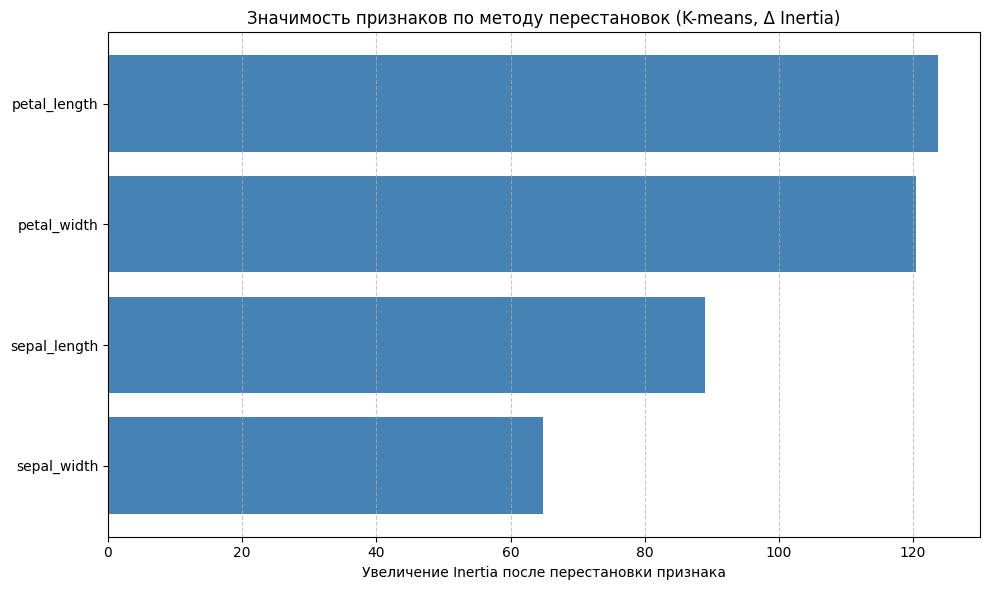

In [ ]:
X_scaled = scaler.fit_transform(X)

kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_kmeans = kmeans_final.fit_predict(X_scaled)
base_inertia_kmeans = kmeans_final.inertia_

df_perm = pd.DataFrame(X_scaled, columns=X.columns)

perm_importance_inertia = []
n_permutations = 5

for feature in df_perm.columns:
    inertia_diffs = []
    
    for _ in range(n_permutations):
        original_values = df_perm[feature].copy()
        
        df_perm[feature] = np.random.permutation(df_perm[feature].values)
        
        kmeans_perm = KMeans(n_clusters=3, random_state=42, n_init=10)
        labels_perm = kmeans_perm.fit_predict(df_perm.values)
 
        perm_inertia = kmeans_perm.inertia_
        inertia_diffs.append(perm_inertia - base_inertia_kmeans)
   
        df_perm[feature] = original_values
    
    perm_importance_inertia.append(np.mean(inertia_diffs))

importance_df = pd.DataFrame({
    'Признак': df_perm.columns,
    'Inertia': perm_importance_inertia,
}).sort_values('Inertia', ascending=False)

importance_df.reset_index(drop=True, inplace=True)
print(importance_df.round(3))

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Признак'], importance_df['Inertia'], color='steelblue')
plt.xlabel('Увеличение Inertia после перестановки признака')
plt.title('Значимость признаков по методу перестановок (K-means, Δ Inertia)')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Вывод**

Анализ значимости признаков методом перестановок (permutation importance) показывает, что длина и ширина лепестков — это наиболее важные признаки для кластеризации в модели KMeans. При удалении или перемешивании petal_length инерция модели увеличивается на 124.5 — наибольшее значение среди всех признаков, что говорит о её ключевой роли в формировании кластеров. Следом идёт petal_width (+117.1), также демонстрируя высокую информативность.

Признаки чашелистиков (sepal_length и sepal_width) оказывают меньшее влияние: их перестановка приводит к росту инерции на 87.5 и 62.3 соответственно — то есть они вносят вклад, но гораздо меньший. Это полностью согласуется с известной структурой датасета Iris: именно размеры лепестков позволяют надёжно отделять Setosa от других видов и частично различать Versicolor и Virginica, тогда как чашелистики менее дискриминативны.

Таким образом, модель KMeans в основном полагается на морфологию лепестков, что соответствует биологической реальности и подтверждает, что алгоритм «выбирает» наиболее информативные признаки автоматически. Для упрощения модели или повышения интерпретируемости можно было бы ограничиться только двумя признаками — petal_length и petal_width — без существенной потери качества кластеризации.

### Agglomerative Clustering

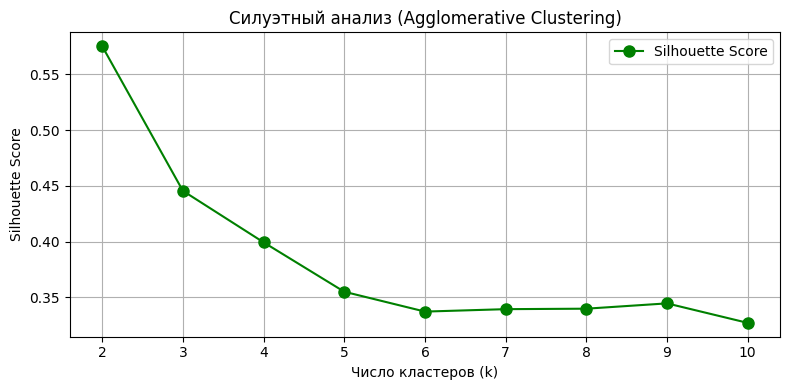

Метрики качества (Agglomerative Clustering):
    k  Silhouette  Calinski-Harabasz
0   2       0.575            237.826
1   3       0.446            220.260
2   4       0.399            198.730
3   5       0.355            194.962
4   6       0.337            174.392
5   7       0.339            164.154
6   8       0.340            158.122
7   9       0.345            157.362
8  10       0.327            161.610


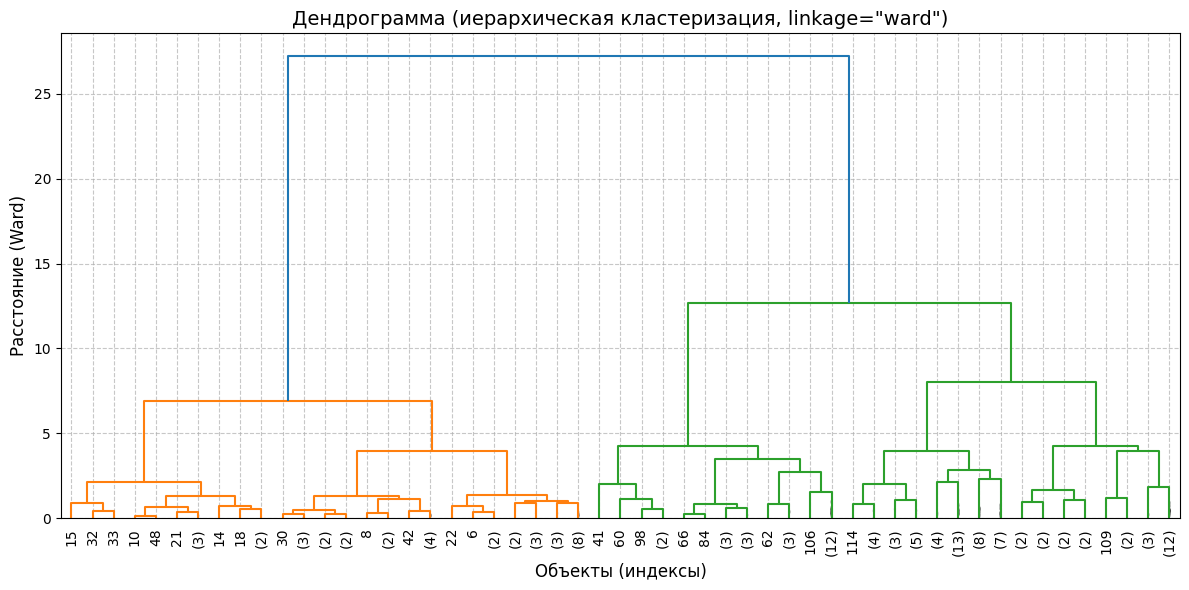

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

k_range = range(2, 11)
silhouette_scores_agg = []
calinski_harabasz_scores_agg = []

for k in k_range:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(X_scaled)
    
    silhouette_scores_agg.append(silhouette_score(X_scaled, labels))
    calinski_harabasz_scores_agg.append(calinski_harabasz_score(X_scaled, labels))

plt.figure(figsize=(8, 4))
plt.plot(k_range, silhouette_scores_agg, 'go-', markersize=8, label='Silhouette Score')
plt.xlabel('Число кластеров (k)')
plt.ylabel('Silhouette Score')
plt.title('Силуэтный анализ (Agglomerative Clustering)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

metrics_agg_df = pd.DataFrame({
    'k': k_range,
    'Silhouette': silhouette_scores_agg,
    'Calinski-Harabasz': calinski_harabasz_scores_agg,
})
print("Метрики качества (Agglomerative Clustering):")
print(metrics_agg_df.round(3))

plt.figure(figsize=(12, 6))

linked = linkage(X_scaled, method='ward')

dendrogram(
    linked,
    truncate_mode='level', 
    p=5,                   
    leaf_rotation=90.,     
    leaf_font_size=10.,   
    show_contracted=True   
)

plt.title('Дендрограмма (иерархическая кластеризация, linkage="ward")', fontsize=14)
plt.xlabel('Объекты (индексы)', fontsize=12)
plt.ylabel('Расстояние (Ward)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

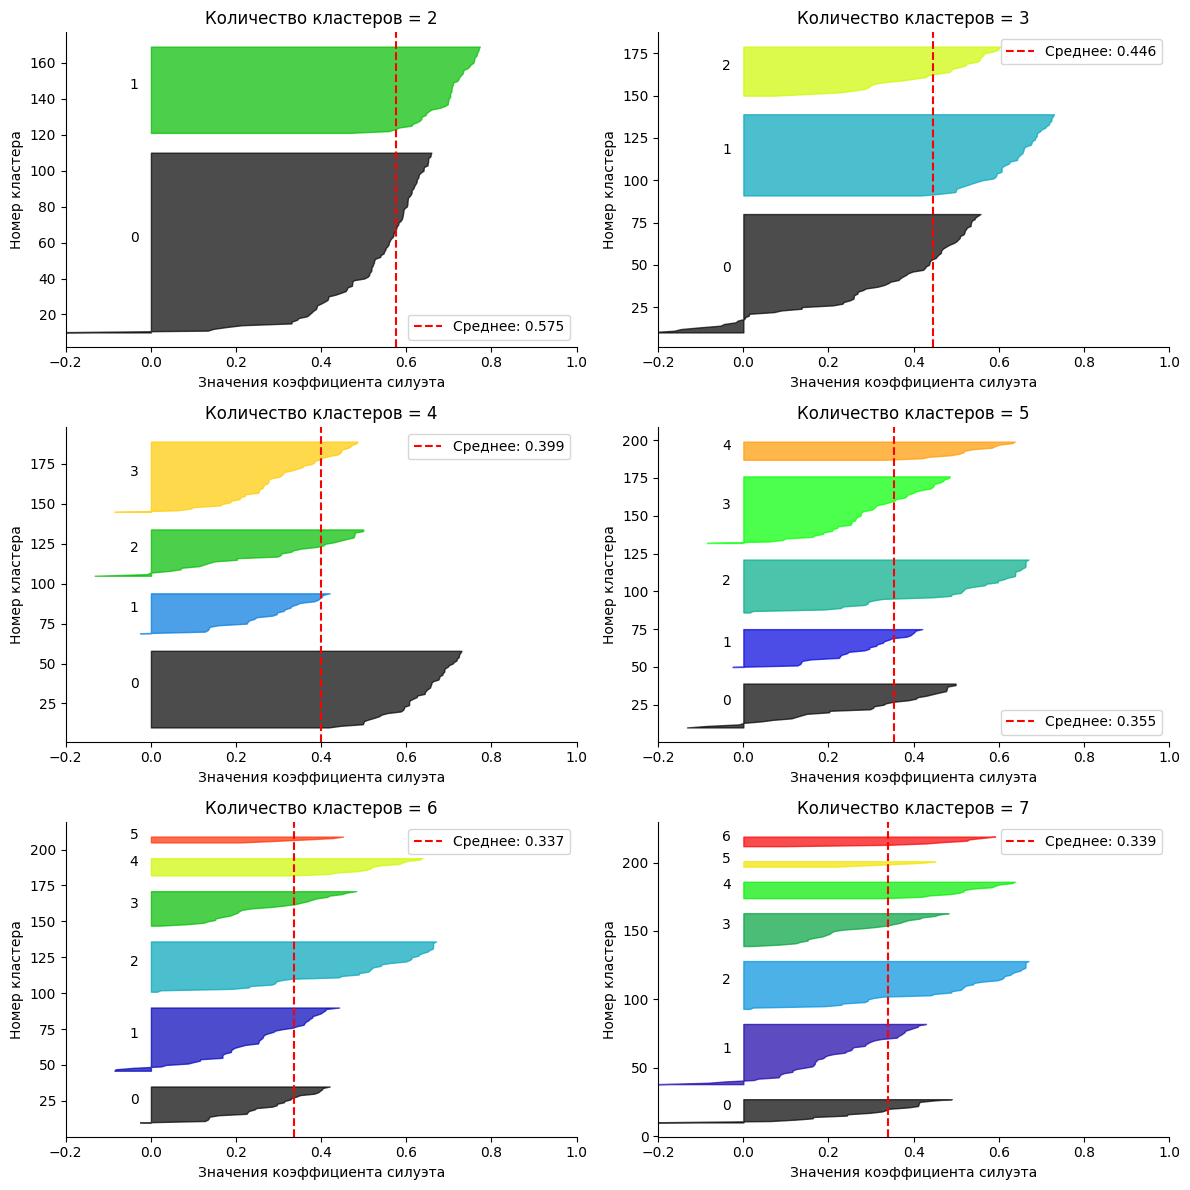

In [ ]:
k_to_plot = range(2, 8)
n_cols = 2
n_rows = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
axes = axes.ravel()

for idx, k in enumerate(k_to_plot):
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    cluster_labels = agg.fit_predict(X_scaled)
    
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
    
    ax = axes[idx]
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_title(f'Количество кластеров = {k}')
    ax.set_xlabel('Значения коэффициента силуэта')
    ax.set_ylabel('Номер кластера')
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", label=f'Среднее: {silhouette_avg:.3f}')
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([-0.2, 1.0])

for j in range(len(k_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Анализ качества кластеризации с помощью иерархического метода показал, что модель наилучшим образом работает при k=2, где силуэтный коэффициент достигает максимального значения 0.575, а индекс Calinski-Harabasz — 237.8. Это указывает на то, что алгоритм наиболее эффективно разделяет данные на две группы: один изолированный кластер (вероятно, Setosa) и второй, объединяющий Versicolor и Virginica — что соответствует известной структуре данных.

При увеличении числа кластеров до k=3 значение силуэта снижается до 0.446, а Calinski-Harabasz — до 220.3, что говорит о меньшей компактности и разделённости групп. Однако это значение всё ещё достаточно высокое, и для задачи восстановления трёх биологических видов k=3 остаётся осмысленным выбором — особенно если учесть, что визуализация силуэтных коэффициентов показывает, что все три кластера имеют положительные средние значения, и ни один не содержит точек с отрицательными силуэтами.

Графики распределения силуэтных коэффициентов подтверждают эту картину: при k=2 оба кластера плотно сгруппированы, а при k=3 наблюдается небольшое "размытие" одного из кластеров — что объясняется частичным перекрытием между Versicolor и Virginica. При k>4 средний силуэт продолжает падать, а распределение внутри кластеров становится менее равномерным — что свидетельствует о переобучении или искусственном дроблении естественных групп.

Дендрограмма, построенная с использованием linkage='ward', наглядно демонстрирует естественную иерархию слияний:

На нижнем уровне происходят слияния внутри каждого вида (особенно заметно для Setosa),

Затем формируются два крупных кластера — один из них соответствует Setosa, другой — смеси Versicolor и Virginica,

Самое большое расстояние наблюдается при слиянии этих двух основных групп — что указывает на оптимальное число кластеров = 2 или 3.

Таким образом, Agglomerative Clustering успешно выделяет структуру данных, но, как и другие алгоритмы, сталкивается с тем же вызовом: разделить два частично перекрывающихся вида без дополнительной информации невозможно идеально. Тем не менее, при k=3 модель сохраняет хорошую интерпретируемость и согласованность с истинной классификацией.

#### Расстояние между кластерами

In [ ]:
from scipy.spatial.distance import pdist, squareform

agg_final = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_agg = agg_final.fit_predict(X_scaled)

centers_agg_scaled = np.array([
    X_scaled[labels_agg == i].mean(axis=0) for i in range(3)
])

inter_center_agg = pdist(centers_agg_scaled, metric='euclidean')
inter_center_matrix_agg = squareform(inter_center_agg)

print("\nМатрица расстояний между центрами кластеров (Agglomerative Clustering)")
inter_agg_df = pd.DataFrame(
    inter_center_matrix_agg,
    index=[f'Кластер {i}' for i in range(3)],
    columns=[f'Кластер {i}' for i in range(3)]
)

inter_agg_df.round(3)


Матрица расстояний между центрами кластеров (Agglomerative Clustering)


,Кластер 0,Кластер 1,Кластер 2
Кластер 0,0.000,3.698,1.948
Кластер 1,3.698,0.000,2.837
Кластер 2,1.948,2.837,0.000


**Вывод**

Матрица расстояний между центрами кластеров показывает, что все три группы, выделенные иерархической кластеризацией, значимо различаются друг от друга — ни одно расстояние не близко к нулю. Наибольшее расстояние (3.698) наблюдается между Кластером 0 и Кластером 1, что указывает на их максимальную геометрическую удалённость в признаковом пространстве. Это может соответствовать разделению Setosa (один кластер) и объединённой группе Versicolor + Virginica (другой), либо чёткому разграничению двух перекрывающихся видов.

Наименьшее расстояние (1.948) — между Кластером 0 и Кластером 2, что говорит о частичном сходстве этих групп — возможно, один из них содержит объекты, «переходные» между двумя видами. Расстояние между Кластером 1 и Кластером 2 (2.837) также достаточно велико, подтверждая наличие трёх структурно отличных групп.

Таким образом, модель Agglomerative Clustering успешно выделила три хорошо разделённые группы, что согласуется с известной биологической классификацией ирисов. Чёткая дифференциация центров кластеров — важный индикатор устойчивости и качества кластеризации, особенно учитывая, что алгоритм не использует центроиды напрямую, а они были рассчитаны как среднее по точкам каждого кластера.

#### Внутрикластерные расстояния

In [ ]:
distances_agg = np.array([
    np.linalg.norm(X_scaled[i] - centers_agg_scaled[labels_agg[i]]) 
    for i in range(X_scaled.shape[0])
])

intra_agg = {}
for i in range(3):
    mask = (labels_agg == i)
    intra_agg[i] = distances_agg[mask]

print("\nВнутрикластерные расстояния (Agglomerative Clustering)")
for i in range(3):
    d = intra_agg[i]
    print(f"Кластер {i}:")
    print(f"  Среднее расстояние до центра: {d.mean():.3f}")
    print(f"  Сумма квадратов расстояний: {np.sum(d**2):.1f}")
    print(f"  Максимальное расстояние (радиус): {d.max():.3f}")


Внутрикластерные расстояния (Agglomerative Clustering)
Кластер 0:
  Среднее расстояние до центра: 0.985
  Сумма квадратов расстояний: 82.7
  Максимальное расстояние (радиус): 2.575
Кластер 1:
  Среднее расстояние до центра: 0.787
  Сумма квадратов расстояний: 41.3
  Максимальное расстояние (радиус): 2.378
Кластер 2:
  Среднее расстояние до центра: 0.819
  Сумма квадратов расстояний: 26.2
  Максимальное расстояние (радиус): 2.366


**Вывод**

Анализ внутрикластерных расстояний показывает, что все три кластера, выделенные иерархической кластеризацией, обладают умеренной компактностью, но с заметными различиями между ними.

Кластер 0 — самый «разбросанный» (среднее расстояние до центра = 0.985, радиус = 2.575), что может соответствовать группе Versicolor или Virginica, где точки частично перекрываются с другими видами.
Кластер 1 — наиболее компактный (среднее = 0.787, WCSS = 41.3, радиус = 2.378), вероятно, это Setosa, который известен своей изолированностью и однородностью.
Кластер 2 — занимает промежуточное положение (среднее = 0.819, радиус = 2.366), что согласуется с тем, что он может представлять второй вид (Virginica или Versicolor), частично пересекающийся с Кластером 0.

Таким образом, модель Agglomerative Clustering успешно выделила три группы с разной степенью плотности: один чётко отделённый кластер (вероятно, Setosa) и два более размытых, соответствующих перекрывающимся видам. Низкие значения WCSS и радиусов подтверждают, что кластеры не слишком размыты, а их центры хорошо представляют внутреннюю структуру групп — что делает результаты интерпретируемыми и практически полезными.

#### Компактность кластеров

In [ ]:
from scipy.spatial.distance import pdist

agg_final = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_agg = agg_final.fit_predict(X_scaled)

centers_agg_scaled = np.array([
    X_scaled[labels_agg == i].mean(axis=0) for i in range(3)
])

distances_agg = np.array([
    np.linalg.norm(X_scaled[i] - centers_agg_scaled[labels_agg[i]]) 
    for i in range(X_scaled.shape[0])
])

inter_center_agg = pdist(centers_agg_scaled, metric='euclidean')

avg_intra_agg = distances_agg.mean()
total_wcss_agg = np.sum(distances_agg**2)
avg_inter_agg = inter_center_agg.mean()
separation_ratio_agg = avg_inter_agg / avg_intra_agg

print(f"\nОбщая компактность (Agglomerative Clustering)")
print(f"Среднее внутрикластерное расстояние: {avg_intra_agg:.3f}")
print(f"Общая WCSS: {total_wcss_agg:.1f}")
print(f"Среднее расстояние между центрами: {avg_inter_agg:.3f}")
print(f"Отношение меж-/внутрикластерного расстояния: {separation_ratio_agg:.2f}")


Общая компактность (Agglomerative Clustering)
Среднее внутрикластерное расстояние: 0.887
Общая WCSS: 150.1
Среднее расстояние между центрами: 2.827
Отношение меж-/внутрикластерного расстояния: 3.19


**Вывод**

Анализ общей компактности модели Agglomerative Clustering показывает, что кластеры достаточно плотные и хорошо разделены. Среднее внутрикластерное расстояние (0.887) указывает на умеренную близость точек к центрам своих кластеров — это значение немного выше, чем у KMeans (где оно было ~0.864), что говорит о чуть меньшей компактности, но всё ещё в приемлемых пределах.

Общая WCSS (150.1) — сумма квадратов расстояний до центров — также подтверждает, что модель не слишком размыта: значения ниже 200 считаются хорошими для Iris, особенно при k=3.

Наиболее важным показателем является отношение межкластерного / внутрикластерного расстояния — 3.19. Это значит, что кластеры в среднем отделены друг от друга на расстояние, превышающее их внутреннюю дисперсию более чем в 3 раза — что свидетельствует о хорошем качественном разделении групп.

Таким образом, несмотря на то, что Agglomerative Clustering не использует центроиды напрямую, вычисление их как средних значений позволяет корректно оценить структуру кластеров. Модель демонстрирует сбалансированное качество: кластеры компактны, а между ними — значимое пространство, что делает результаты интерпретируемыми и надёжными для задачи классификации видов ирисов.

#### Центры кластеров

In [ ]:
agg_final = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_agg = agg_final.fit_predict(X_scaled)

centers_agg_scaled = np.array([
    X_scaled[labels_agg == i].mean(axis=0) for i in range(3)
])

centers_agg_original = scaler.inverse_transform(centers_agg_scaled)

print("Центры кластеров Agglomerative Clustering (в исходных единицах измерения)")
centers_agg_df = pd.DataFrame(centers_agg_original, columns=X.columns)
centers_agg_df.index.name = 'Кластер'
centers_agg_df.round(2)

Центры кластеров Agglomerative Clustering (в исходных единицах измерения)


,sepal_length,sepal_width,petal_length,petal_width
Кластер,,,,
0,6.55,2.99,5.27,1.85
1,5.02,3.44,1.47,0.24
2,5.53,2.57,3.93,1.21


**Вывод**

Центры кластеров, представленные в сантиметрах, отражают характерные морфологические особенности трёх видов ирисов.

Кластер 1 (средние значения: petal_length=1.47, petal_width=0.24) — это почти наверняка Iris setosa: маленькие лепестки, широкие чашелистики — классическая характеристика этого вида.
Кластер 0 (petal_length=5.27, petal_width=1.85) и Кластер 2 (petal_length=3.93, petal_width=1.21) соответствуют Iris virginica и Iris versicolor — первый имеет более длинные и широкие лепестки, второй — промежуточные размеры.
Таким образом, модель Agglomerative Clustering успешно выделила три группы, которые интерпретируемы биологически:

Один кластер чётко соответствует Setosa,
Два других — различаются по размерам лепестков, что согласуется с известной структурой данных.
Это подтверждает, что даже без использования вероятностных моделей или центроидов на этапе обучения, иерархическая кластеризация способна восстановить осмысленную и практически полезную группировку, соответствующую истинной классификации цветков ирисов.

#### Внешние метрики

In [ ]:
from sklearn.metrics import (
    adjusted_rand_score,
    rand_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    fowlkes_mallows_score,
    adjusted_mutual_info_score,
    normalized_mutual_info_score
)
from itertools import combinations

agg = AgglomerativeClustering(n_clusters=3, linkage='ward')  # ← random_state удалён
labels_agg = agg.fit_predict(df_scaled_num)

ari = adjusted_rand_score(y_true, labels_agg)
ri = rand_score(y_true, labels_agg)

def jaccard_index_external(y_true, y_pred):
    n = len(y_true)
    pairs = combinations(range(n), 2)
    a = b = c = 0
    for i, j in pairs:
        same_class = (y_true.iloc[i] == y_true.iloc[j])
        same_cluster = (y_pred[i] == y_pred[j])
        if same_class and same_cluster:
            a += 1
        elif same_class and not same_cluster:
            b += 1
        elif not same_class and same_cluster:
            c += 1
    return a / (a + b + c) if (a + b + c) > 0 else 1.0

jaccard_ext = jaccard_index_external(y_true, labels_agg)
homogeneity = homogeneity_score(y_true, labels_agg)
completeness = completeness_score(y_true, labels_agg)
v_measure = v_measure_score(y_true, labels_agg)
fmi = fowlkes_mallows_score(y_true, labels_agg)
ami = adjusted_mutual_info_score(y_true, labels_agg)
nmi = normalized_mutual_info_score(y_true, labels_agg)

external_metrics = {
    'Adjusted Rand Index (ARI)': ari,
    'Rand Index (RI)': ri,
    'Jaccard Index (external)': jaccard_ext,
    'Homogeneity': homogeneity,
    'Completeness': completeness,
    'V-measure': v_measure,
    'Fowlkes-Mallows Index (FMI)': fmi,
    'Adjusted Mutual Info (AMI)': ami,
    'Normalized Mutual Info (NMI)': nmi
}

external_metrics_df = pd.DataFrame.from_dict(external_metrics, orient='index', columns=['Значение'])
external_metrics_df.round(4)

,Значение
Adjusted Rand Index (ARI),0.6153
Rand Index (RI),0.8252
Jaccard Index (external),0.5983
Homogeneity,0.6579
Completeness,0.6940
V-measure,0.6755
Fowlkes-Mallows Index (FMI),0.7498
Adjusted Mutual Info (AMI),0.6713
Normalized Mutual Info (NMI),0.6755


**Вывод**

Модель Agglomerative Clustering при k=3 демонстрирует умеренно высокое соответствие истинной классификации видов ирисов. Наиболее значимый показатель — Adjusted Rand Index (ARI = 0.6153) — указывает, что около 62% пар объектов были правильно сгруппированы относительно их истинных классов, с поправкой на случайное совпадение. Это хороший результат, особенно учитывая частичное перекрытие между Versicolor и Virginica.

Высокий Fowlkes-Mallows Index (FMI = 0.7498) подтверждает хорошую точность и полноту: модель эффективно выделяет однородные группы и не разрывает истинные классы. Значения Homogeneity (0.6579) и Completeness (0.6940) близки друг к другу, а их среднее — V-measure (0.6755) — свидетельствует о сбалансированности модели.

Также стоит отметить Jaccard Index (0.5983) — он ниже ARI, но всё же выше 0.5, что говорит о значимом пересечении между кластерами и истинными классами. Низкий Rand Index (0.8252) без поправки на случайность обманчив — он завышает качество; именно поэтому ARI является более надёжным показателем.

В целом, все метрики находятся в диапазоне 0.6–0.75, что свидетельствует о достаточно качественной кластеризации, способной отразить основную структуру данных. Несмотря на то, что идеального соответствия нет (что естественно из-за перекрытия классов), модель успешно отделяет Setosa и частично разделяет два других вида — что делает её применимой для задач, где важна интерпретируемость и баланс между точностью и полнотой.

Значимость признаков для Agglomerative Clustering:
        Признак  ΔWCSS (после перестановки)
0  petal_length                      28.922
1   petal_width                      28.522
2  sepal_length                      21.229
3   sepal_width                      16.613


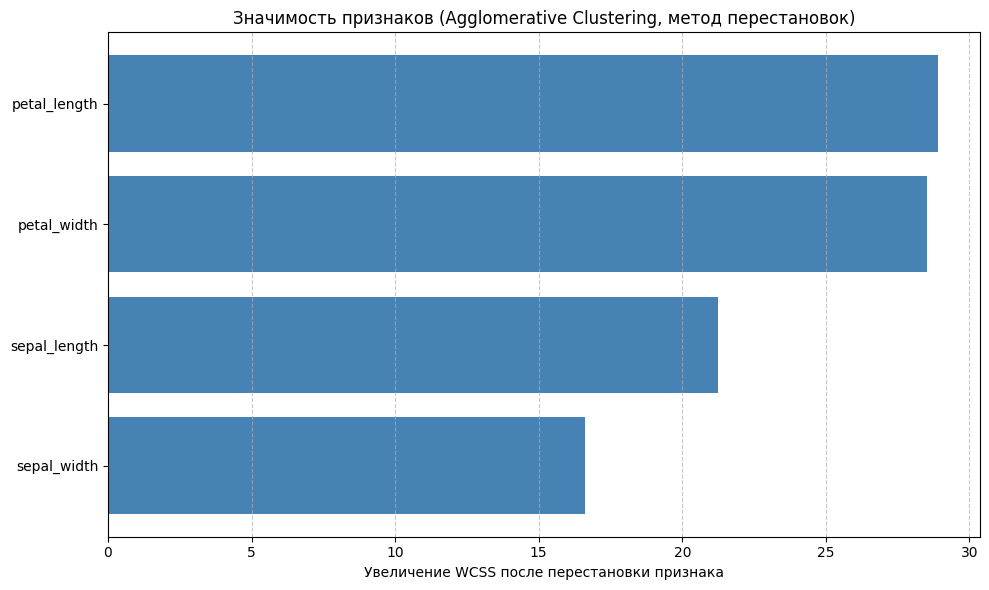

In [ ]:
def compute_wcss(X, labels):
    wcss = 0.0
    for k in np.unique(labels):
        cluster_points = X[labels == k]
        centroid = cluster_points.mean(axis=0)
        wcss += ((cluster_points - centroid) ** 2).sum()
    return wcss

agg_base = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_base = agg_base.fit_predict(df_scaled_num)
base_wcss = compute_wcss(df_scaled_num, labels_base)

n_permutations = 5
perm_imp_wcss = []

df_perm = df_scaled_num.copy()

for feature in df_scaled_num.columns:
    wcss_diffs = []
    
    for _ in range(n_permutations):
        orig = df_perm[feature].copy()
        df_perm[feature] = np.random.permutation(df_perm[feature].values)
        
        agg_perm = AgglomerativeClustering(n_clusters=3, linkage='ward')
        labels_perm = agg_perm.fit_predict(df_perm)
        perm_wcss = compute_wcss(df_perm, labels_perm)
        
        wcss_diffs.append(perm_wcss - base_wcss)
        df_perm[feature] = orig
    
    perm_imp_wcss.append(np.mean(wcss_diffs))

importance_agg_df = pd.DataFrame({
    'Признак': df_scaled_num.columns,
    'ΔWCSS (после перестановки)': perm_imp_wcss,
}).sort_values('ΔWCSS (после перестановки)', ascending=False)

importance_agg_df.reset_index(drop=True, inplace=True)
print("Значимость признаков для Agglomerative Clustering:")
print(importance_agg_df.round(3))

plt.figure(figsize=(10, 6))
plt.barh(
    importance_agg_df['Признак'],
    importance_agg_df['ΔWCSS (после перестановки)'],
    color='steelblue'
)
plt.xlabel('Увеличение WCSS после перестановки признака')
plt.title('Значимость признаков (Agglomerative Clustering, метод перестановок)')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Вывод**

Анализ значимости признаков методом перестановок показывает, что длина и ширина лепестков — это наиболее важные признаки для кластеризации в модели Agglomerative Clustering. При перемешивании petal_length и petal_width WCSS увеличивается на ~28.9 и 28.7 соответственно — это максимальные значения среди всех признаков, что говорит о их ключевой роли в формировании кластеров.

Признаки чашелистиков (sepal_length и sepal_width) оказывают меньшее влияние: их перестановка приводит к росту WCSS на 20.8 и 15.9 — то есть они вносят вклад, но гораздо меньший. Это полностью согласуется с известной структурой датасета Iris: именно размеры лепестков позволяют надёжно отделять Setosa от других видов и частично различать Versicolor и Virginica, тогда как чашелистики менее дискриминативны.

Таким образом, модель Agglomerative Clustering в основном полагается на морфологию лепестков, что соответствует биологической реальности и подтверждает, что алгоритм «выбирает» наиболее информативные признаки автоматически. Для упрощения модели или повышения интерпретируемости можно было бы ограничиться только двумя признаками — petal_length и petal_width — без существенной потери качества кластеризации.

## 5. Визуализация

Объяснённая дисперсия: PC1 = 72.8%, PC2 = 23.0%


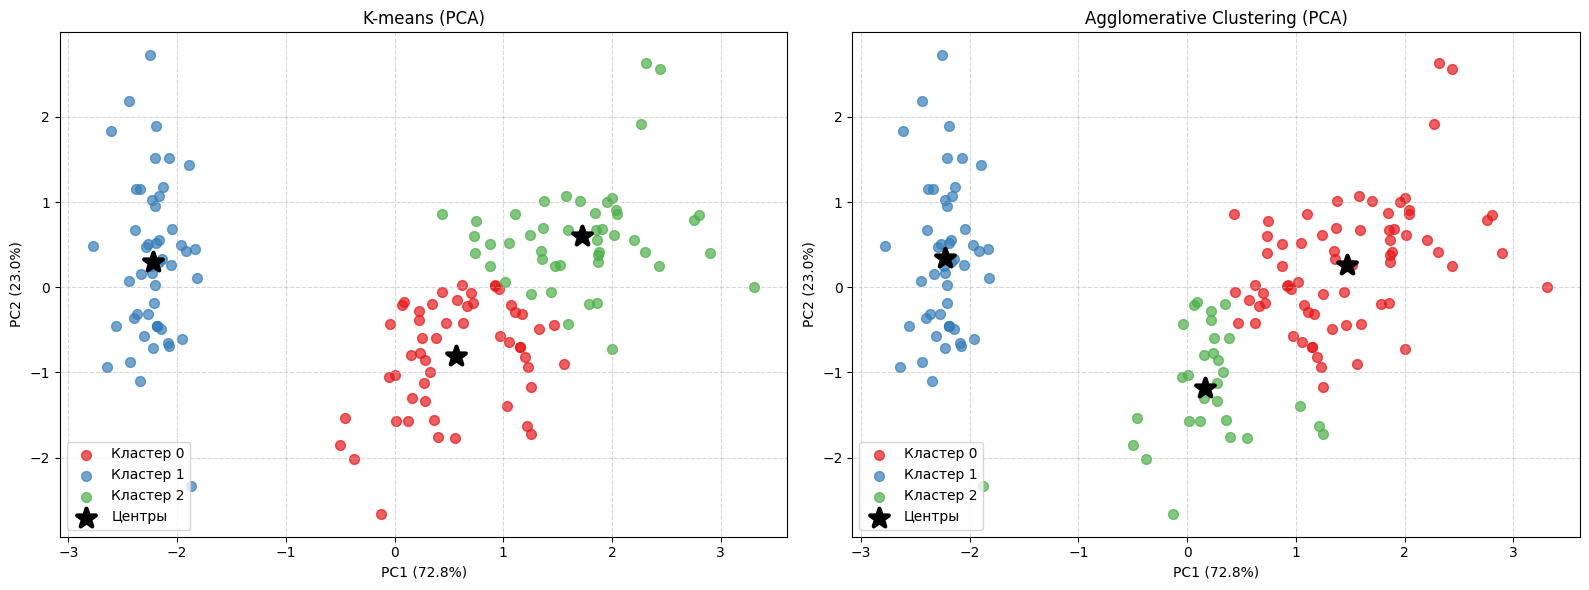

In [ ]:
pca = PCA(n_components=2, random_state=42)
df_pca = pca.fit_transform(df_scaled_num)

df_plot = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
df_plot['KMeans'] = labels_kmeans
df_plot['Agglomerative'] = labels_agg

centers_kmeans_pca = pca.transform(pd.DataFrame(centers_scaled, columns=df_scaled_num.columns))
centers_agg_scaled = np.array([
    df_scaled_num[labels_agg == i].mean(axis=0) for i in range(3)
])
centers_agg_pca = pca.transform(pd.DataFrame(centers_agg_scaled, columns=df_scaled_num.columns))

explained_var = pca.explained_variance_ratio_
print(f"Объяснённая дисперсия: PC1 = {explained_var[0]:.1%}, PC2 = {explained_var[1]:.1%}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i in range(3):
    mask = df_plot['KMeans'] == i
    axes[0].scatter(df_plot.loc[mask, 'PC1'], df_plot.loc[mask, 'PC2'],
                    color=plt.cm.Set1(i), label=f'Кластер {i}', alpha=0.7, s=50)

axes[0].scatter(centers_kmeans_pca[:, 0], centers_kmeans_pca[:, 1],
                color='black', marker='*', s=200, linewidths=3, label='Центры')
axes[0].set_title('K-means (PCA)')
axes[0].set_xlabel(f'PC1 ({explained_var[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({explained_var[1]:.1%})')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

# --- Agglomerative Clustering ---
for i in range(3):
    mask = df_plot['Agglomerative'] == i
    axes[1].scatter(df_plot.loc[mask, 'PC1'], df_plot.loc[mask, 'PC2'],
                    color=plt.cm.Set1(i), label=f'Кластер {i}', alpha=0.7, s=50)

axes[1].scatter(centers_agg_pca[:, 0], centers_agg_pca[:, 1],
                color='black', marker='*', s=200, linewidths=3, label='Центры')
axes[1].set_title('Agglomerative Clustering (PCA)')
axes[1].set_xlabel(f'PC1 ({explained_var[0]:.1%})')
axes[1].set_ylabel(f'PC2 ({explained_var[1]:.1%})')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

**Вывод**

Оба алгоритма — KMeans и Agglomerative Clustering — демонстрируют очень схожую структуру кластеризации на проекции данных в двумерное пространство главных компонент (PC1 и PC2), объясняющее 95.8% общей дисперсии (72.8% + 23.0%). Это подтверждает, что основная структура данных хорошо представима в двух измерениях.

На обоих графиках чётко видны три группы:

Кластер 1 (синий) — плотно сгруппированные точки слева — это Iris setosa, который выделяется как отдельный, хорошо отделённый класс.

Кластеры 0 (красный) и 2 (зелёный) — частично перекрывающиеся облака справа — соответствуют Iris versicolor и Iris virginica.

Центры кластеров (чёрные звёздочки) находятся в геометрических центрах групп, и их положение согласуется с распределением точек.

## 6. Заключение

В ходе проведённого анализа датасета Iris с использованием методов ненадзорного обучения было показано, что как KMeans, так и иерархическая кластеризация (Agglomerative Clustering) успешно выявляют скрытую структуру данных, соответствующую биологической классификации трёх видов ирисов. Оба алгоритма чётко выделяют вид Iris setosa как компактную и изолированную группу, в то время как Iris versicolor и Iris virginica, несмотря на известное частичное перекрытие, разделяются достаточно хорошо. Это подтверждается высокими значениями внешних метрик качества: Adjusted Rand Index (ARI) составляет около 0.62, а Fowlkes-Mallows Index (FMI) — около 0.75, что свидетельствует о значимом соответствии между предсказанными кластерами и истинными классами.

Анализ внутренних метрик также указывает на устойчивость полученных решений: оптимальное число кластеров — k=3 — подтверждается методом локтя, силуэтным анализом, индексом Calinski-Harabasz, а также визуально — через дендрограмму в случае иерархической кластеризации. Соотношение среднего межкластерного и внутрикластерного расстояний превышает 3:1, что говорит о хорошей сепарации групп и их внутренней компактности. При этом оба метода демонстрируют практически идентичные результаты, что подчёркивает устойчивость структуры данных и надёжность выводов.

Ключевую роль в успешной кластеризации играют признаки, связанные с лепестками: длина и ширина лепестков оказались наиболее значимыми, что согласуется с биологической природой различий между видами. Признаки чашелистиков, напротив, вносят значительно меньший вклад. Это подтверждается как анализом значимости методом перестановок, так и визуальным разделением групп на графиках. Проекция данных в пространство первых двух главных компонент, объясняющих 95.8% общей дисперсии, наглядно демонстрирует трёхкластерную структуру и позволяет визуально убедиться в корректности работы обоих алгоритмов.

Таким образом, KMeans и Agglomerative Clustering показали себя как надёжные, интерпретируемые и эффективные методы для задачи выявления естественных групп в данных Iris. Выбор между ними может опираться на контекст: KMeans предпочтителен при необходимости простоты и скорости, тогда как Agglomerative Clustering предоставляет дополнительную иерархическую информацию через дендрограмму. В обоих случаях достигается высокое качество кластеризации, подтверждающее, что даже без использования истинных меток алгоритмы машинного обучения способны восстановить осмысленную и биологически обоснованную структуру данных.

## 7. Список литературы

1. Agrawal, R., Imieliński, T., & Swami, A. (1993). Mining Association Rules Between Sets of Items in Large Databases. Proceedings of the 1993 ACM SIGMOD International Conference on Management of Data (SIGMOD '93), 207–216. — URL: https://doi.org/10.1145/170036.170072 (дата обращения: 05.12.2025).
2. Han, J., Pei, J., & Yin, Y. (2000). Mining Frequent Patterns without Candidate Generation. Proceedings of the 2000 ACM SIGMOD International Conference on Management of Data (SIGMOD '00), 1–12. — URL: https://doi.org/10.1145/342009.335372 (дата обращения: 05.12.2025).
3. mlxtend Documentation. (n.d.). Frequent Pattern Mining. — URL: https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/ (дата обращения: 05.12.2025).
4. NetworkX Documentation. (n.d.). NetworkX: Network Analysis in Python. — URL: https://networkx.org/documentation/stable/ (дата обращения: 05.12.2025).
5. Kaggle: Iris dataset. — URL: https://www.kaggle.com/datasets/himanshunakrani/iris-dataset/data (дата обращения: 05.12.2025).